In [88]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
#https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
import json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
sw_nltk.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
import re
import spacy
import os

from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_val_score, )
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tomotopy import HDPModel

#from lda_classification.model import TomotopyLDAVectorizer
#from lda_classification.preprocess.spacy_cleaner import SpacyCleaner
import gensim
import gensim.corpora as corpora
import pyLDAvis
#import pyLDAvis.gensim_models as gensim
pyLDAvis.enable_notebook()
#import pyLDAvis.gensim
import pickle 

from matplotlib import pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = 4 #Numbers of workers throughout the project
use_umap = False #make this True if you want to use UMAP for your visualizations
min_df = 5 #Minimum number for document frequency in the corpus
rm_top = 5 #Remove top n frequent words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
#lem for lemmatization, stem for stemmatizing
def preprocess(data, type="lem"):
    words = set(nltk.corpus.words.words())
    preprocessed_data = []
    for x in data:
        #Lowerize
        x = x.lower()
        #Eliminate special characters
        x = re.sub(r'\d+', '', x)
        x = re.sub(' +', ' ', x.translate ({ord(c): "" for c in "!@#$%^&*()[]{};:,./<>?\\|'`~-=_+"}).strip())
        
        #Eliminate stop words
        words = [word for word in x.split() if word not in sw_nltk] 
        x = " ".join(words)

        #Stemming / Lemmatizing
        words = word_tokenize(x)
        rootWords = []
        if type=='stem':
                ps = PorterStemmer()
                rootWords.append(ps.stem(w))
        else:
            for w in words:
                wordnet_lemmatizer = WordNetLemmatizer()
                rootWords.append(wordnet_lemmatizer.lemmatize(w))

        x = x.split(' ')
        #x = TreebankWordDetokenizer().detokenize(rootWords)

        nlp = spacy.load("en_core_web_sm")
        
        article = []
        for sent in x:
            doc = nlp(sent)
            j = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]
            
            if (j != []):
                #print(j)
                #print(j[0] in words)
                #print(j[0].isalpha())
                if((j[0] in words) or (j[0].isalpha())):
                    article.append(j[0])
        
        if article != []:
            preprocessed_data.append(article)

        #print(article)
    return preprocessed_data
        
    


#preprocess(['Hsf##123 14: . ; ,  45', 'Blu34%& 22', 'as fine as good', 'found, find, go, went', 'studies studying cries cry'])

In [10]:
#Carefull!!! Takes about 90 minutes! If you already have a model saved, then use the prep_arr() class!!!!


# Opening JSON file
f_queries = open('Queries_Labeled.json',)
f_collection = open('collection.json')
 
# returns JSON object as
# a dictionary
data_queries = json.load(f_queries)
data_collection = json.load(f_collection)

# Iterating through the json
# list
#for i in data['documents']:
#    print(i)

queries = data_queries['documents']
collection = data_collection['TREC']['DOC']
#print(len(queries))
#print(len(collection))

# Closing file
f_queries.close()
f_collection.close()

prep_collection = []
for x in collection:
    prep_collection.append(x['text'])
prep_collection = preprocess(prep_collection)

prep_queries = []
for x in queries:
    prep_queries.append(x['text'])
prep_queries = preprocess(prep_queries)

#print(prep_queries)
#print(prep_collection)

In [90]:
#Savable data array class
class prep_arr(object):
    def __init__(self, data_arr=[]):
        self.data_arr = data_arr

    def save(self, path):
        with open(path, 'wb') as outp:
            pickle.dump(self, outp, pickle.HIGHEST_PROTOCOL)

    def load(self, path):
        with open(path, 'rb') as inp:
            prep_arr_load = pickle.load(inp)
        self.data_arr = prep_arr_load.data_arr
    

In [223]:
#Save cleaned arrays
arr_q = prep_arr(prep_queries)
arr_q.save("./cleaned_data/prep_queries.txt")
arr_c = prep_arr(prep_collection)
arr_c.save("./cleaned_data/prep_collection.txt")

In [224]:
#Load the saved arrays
load_q = prep_arr()
load_q.load("./cleaned_data/prep_queries.txt")
prep_queries = load_q.data_arr

load_c = prep_arr()
load_c.load("./cleaned_data/prep_collection.txt")
prep_collection = load_c.data_arr


In [225]:
print(len(prep_collection))
print(len(prep_queries))

7849
50


In [226]:
# Create Dictionary
id2word = corpora.Dictionary(prep_collection)
# Create Corpus
texts = prep_collection
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [227]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"information" + 0.012*"library" + 0.010*"system" + 0.008*"use" + '
  '0.008*"service" + 0.007*"datum" + 0.006*"method" + 0.005*"give" + '
  '0.005*"book" + 0.005*"computer"'),
 (1,
  '0.007*"frequency" + 0.006*"result" + 0.006*"datum" + 0.005*"electron" + '
  '0.005*"give" + 0.005*"use" + 0.005*"time" + 0.005*"circuit" + 0.005*"wave" '
  '+ 0.005*"radio"'),
 (2,
  '0.012*"library" + 0.006*"discuss" + 0.006*"information" + 0.006*"describe" '
  '+ 0.006*"work" + 0.005*"present" + 0.005*"program" + 0.004*"book" + '
  '0.004*"system" + 0.004*"network"'),
 (3,
  '0.021*"system" + 0.009*"library" + 0.008*"use" + 0.007*"information" + '
  '0.006*"datum" + 0.006*"circuit" + 0.006*"describe" + 0.005*"discuss" + '
  '0.005*"method" + 0.005*"network"'),
 (4,
  '0.010*"system" + 0.007*"frequency" + 0.007*"effect" + 0.007*"theory" + '
  '0.006*"field" + 0.005*"method" + 0.005*"analysis" + 0.004*"result" + '
  '0.004*"high" + 0.004*"magnetic"'),
 (5,
  '0.011*"information" + 0.008*"giv

In [228]:
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    #LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.045384 -0.005574       1        1  16.819047
8      0.054155  0.023270       2        1  16.191626
7     -0.053230 -0.002358       3        1  15.534396
3     -0.029962  0.002404       4        1  10.777217
1      0.036503 -0.019450       5        1  10.476953
4      0.025390 -0.012154       6        1   7.454744
6      0.061231  0.008625       7        1   6.447480
9     -0.016283 -0.039701       8        1   5.913011
5      0.002594 -0.003967       9        1   5.820276
2     -0.035013  0.048906      10        1   4.565249, topic_info=            Term         Freq        Total Category  logprob  loglift
200  information  1989.000000  1989.000000  Default  30.0000  30.0000
160       system  2205.000000  2205.000000  Default  29.0000  29.0000
87       library  1509.000000  1509.000000  Default  28.0000  28.0000
394    frequency  1235.000000  1235.000000  Default  27.0000  27.0000
868    amplifier   723.000000   723.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
254       method    35.987581  1202.891284  Topic10  -5.7441  -0.4226
198      general    28.348006   489.041538  Topic10  -5.9828   0.2388
355      current    29.109220   552.288688  Topic10  -5.9563   0.1437
492         time    30.784360   774.444492  Topic10  -5.9003  -0.1384
63           use    30.424619  1548.391695  Topic10  -5.9121  -0.8430

[868 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3129      1  0.270734      aacr
3129      2  0.067684      aacr
3129      3  0.496346      aacr
3129      4  0.022561      aacr
3129      5  0.067684      aacr
...     ...       ...       ...
100       9  0.057762      year
100      10  0.063842      year
2422      9  0.462177   yttrium
5243      1  0.887992       zbb
5244      1  0.694595  zerobase

[2881 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 8, 4, 2, 5, 7, 10, 6, 3])

In [229]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=collection):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=prep_collection)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.8713,"information, use, system, datum, pm, problem, university, describe, discuss, give","[computer, university, part, reeve, r, pm]"
1,1,0.0,0.6614,"information, library, system, use, service, datum, method, give, book, computer","[use, synthetic, image, register, real, image, surface, model, number, image, analysis, task, be..."
2,2,9.0,0.5597,"information, use, system, datum, pm, problem, university, describe, discuss, give","[training, assistant, mauritius, university, mauritius, financial, help, international, developm..."
3,3,0.0,0.7748,"information, library, system, use, service, datum, method, give, book, computer","[electrostatic, centre, conductor]"
4,4,1.0,0.5288,"frequency, result, datum, electron, give, use, time, circuit, wave, radio","[note, interpretation, transient, echo, ionosphere, comment, note, recent, radio, work, meteor, ..."
...,...,...,...,...,...
95,95,7.0,0.9873,"information, system, service, library, describe, function, datum, discuss, present, network","[midf, form, malaysian, industrial, development, finance, berhad, midf, become, country, lead, d..."
96,96,7.0,0.9852,"information, system, service, library, describe, function, datum, discuss, present, network","[network, revise, version, paper, present, meeting, regional, cooperation, deventer, netherland,..."
97,97,3.0,0.9769,"system, library, use, information, datum, circuit, describe, discuss, method, network","[public, public, library, represent, ideal, goal, always, pursue, real, practice, follow, nihili..."
98,98,8.0,0.5449,"circuit, use, field, electron, magnetic, give, amplifier, describe, frequency, effect","[stabilization, direct, voltage, supply, functional, diagram, propose, study, control, stabiliza..."


In [230]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9914,"information, library, system, use, service, datum, method, give, book, computer","[british, lending, division, swedish, blld, form, amalgamation, national, central, national, len..."
1,1.0,0.9928,"frequency, result, datum, electron, give, use, time, circuit, wave, radio","[method, obtain, signature, cryptosystem, encryption, method, present, novel, property, publicly..."
2,2.0,0.9911,"library, discuss, information, describe, work, present, program, book, system, network","[language, information, retrieval, remote, typewriter, console, english, natural, command, langu..."
3,3.0,0.9941,"system, library, use, information, datum, circuit, describe, discuss, method, network","[requirement, advanced, programming, system, list, processing, list, processing, system, design,..."
4,4.0,0.9921,"system, frequency, effect, theory, field, method, analysis, result, high, magnetic","[external, storage, fragmentation, produce, firstfit, allocation, strategy, publish, comparison,..."
5,5.0,0.9922,"information, give, system, use, frequency, study, method, field, analysis, amplifier","[highlevel, datum, flow, analysis, contrast, predominant, lowlevel, termediate, text, highlevel,..."
6,6.0,0.9895,"frequency, describe, method, use, give, design, equation, amplifier, type, characteristic","[measurement, term, importance, automatic, index, frequency, characteristic, term, document, col..."
7,7.0,0.9927,"information, system, service, library, describe, function, datum, discuss, present, network","[technology, information, professional, difference, examine, likely, impact, new, technology, li..."
8,8.0,0.9881,"circuit, use, field, electron, magnetic, give, amplifier, describe, frequency, effect","[lucid, nonprocedural, language, iteration, lucid, formal, system, program, write, proof, progra..."
9,9.0,0.9924,"information, use, system, datum, pm, problem, university, describe, discuss, give","[compute, capability, argentine, chilean, university, author, report, trip, university, chile, d..."


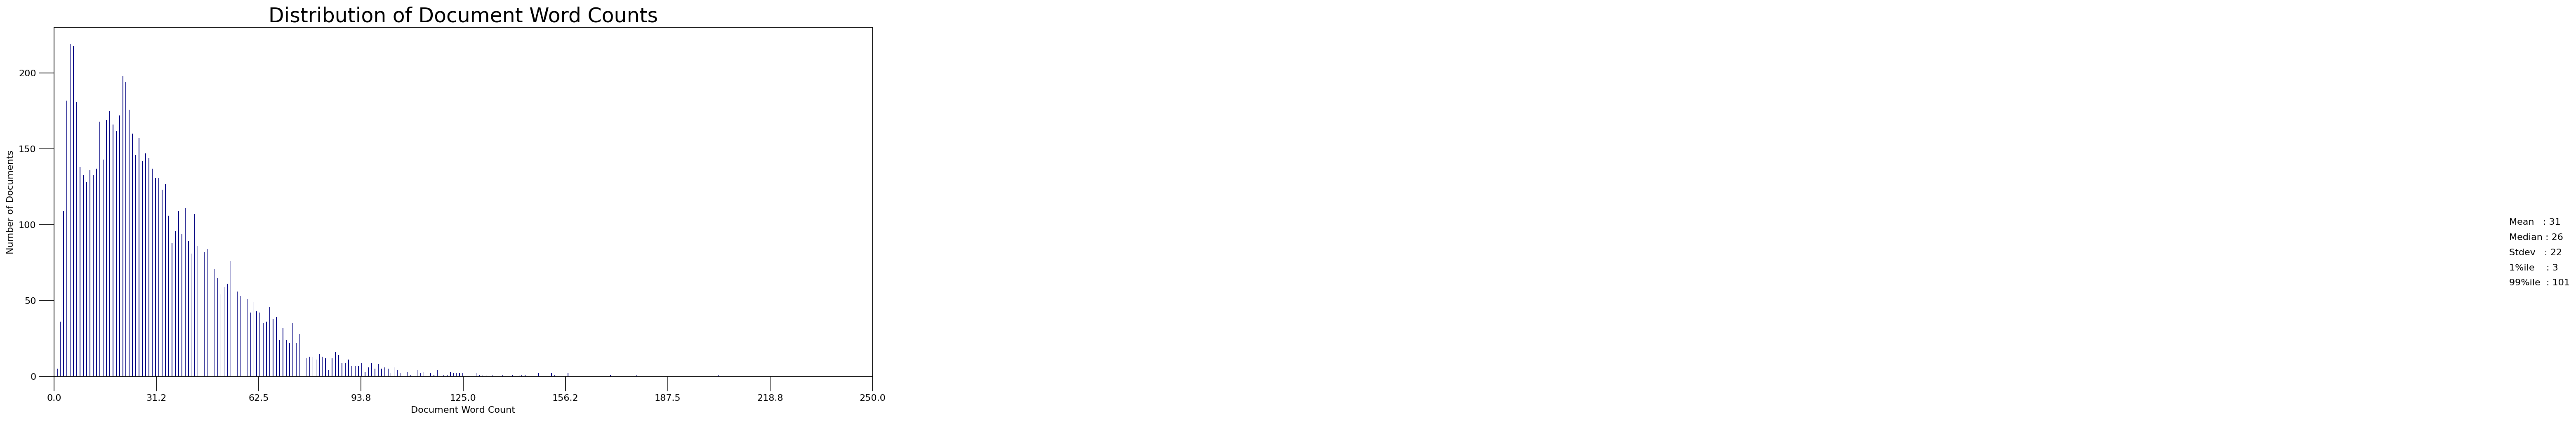

In [231]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 250), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,250,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

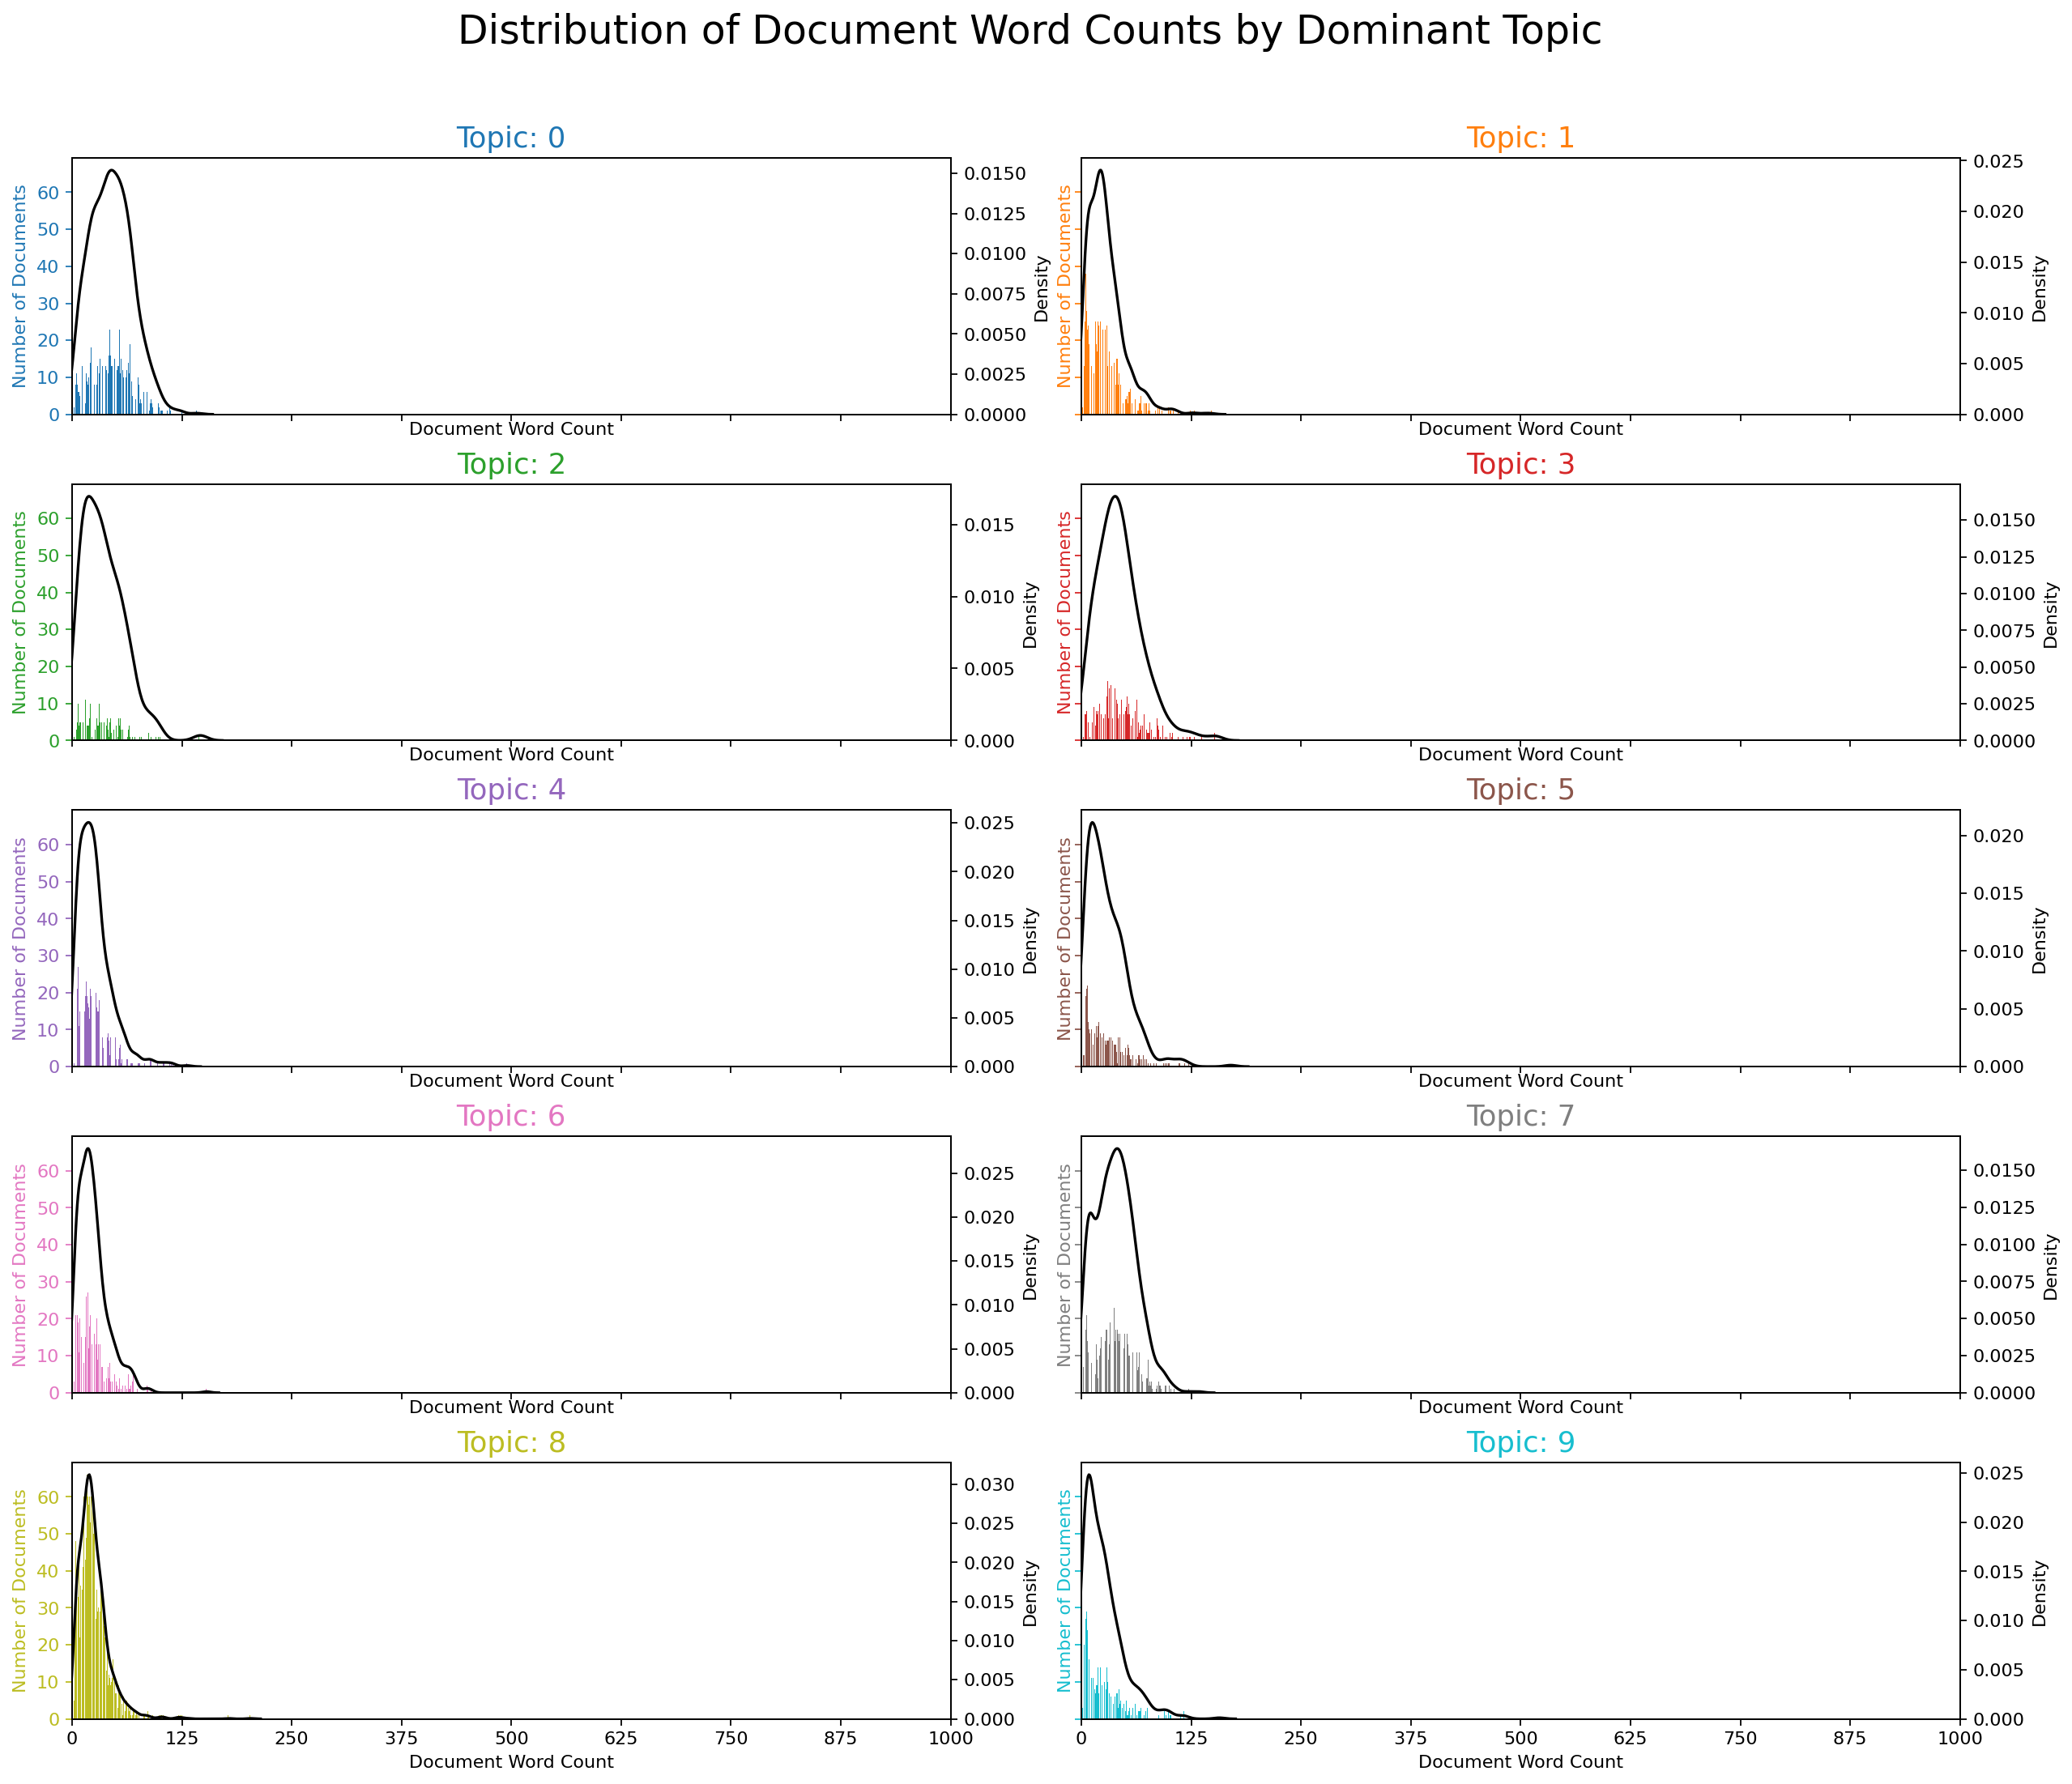

In [232]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 250, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

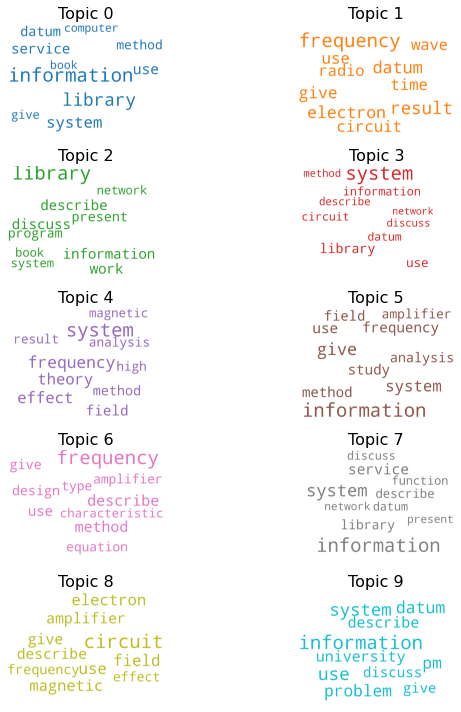

In [233]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\TEMP/ipykernel_20592/2230375264.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_20592/2230375264.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_20592/2230375264.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_20592/2230375264.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_20592/2230375264.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.

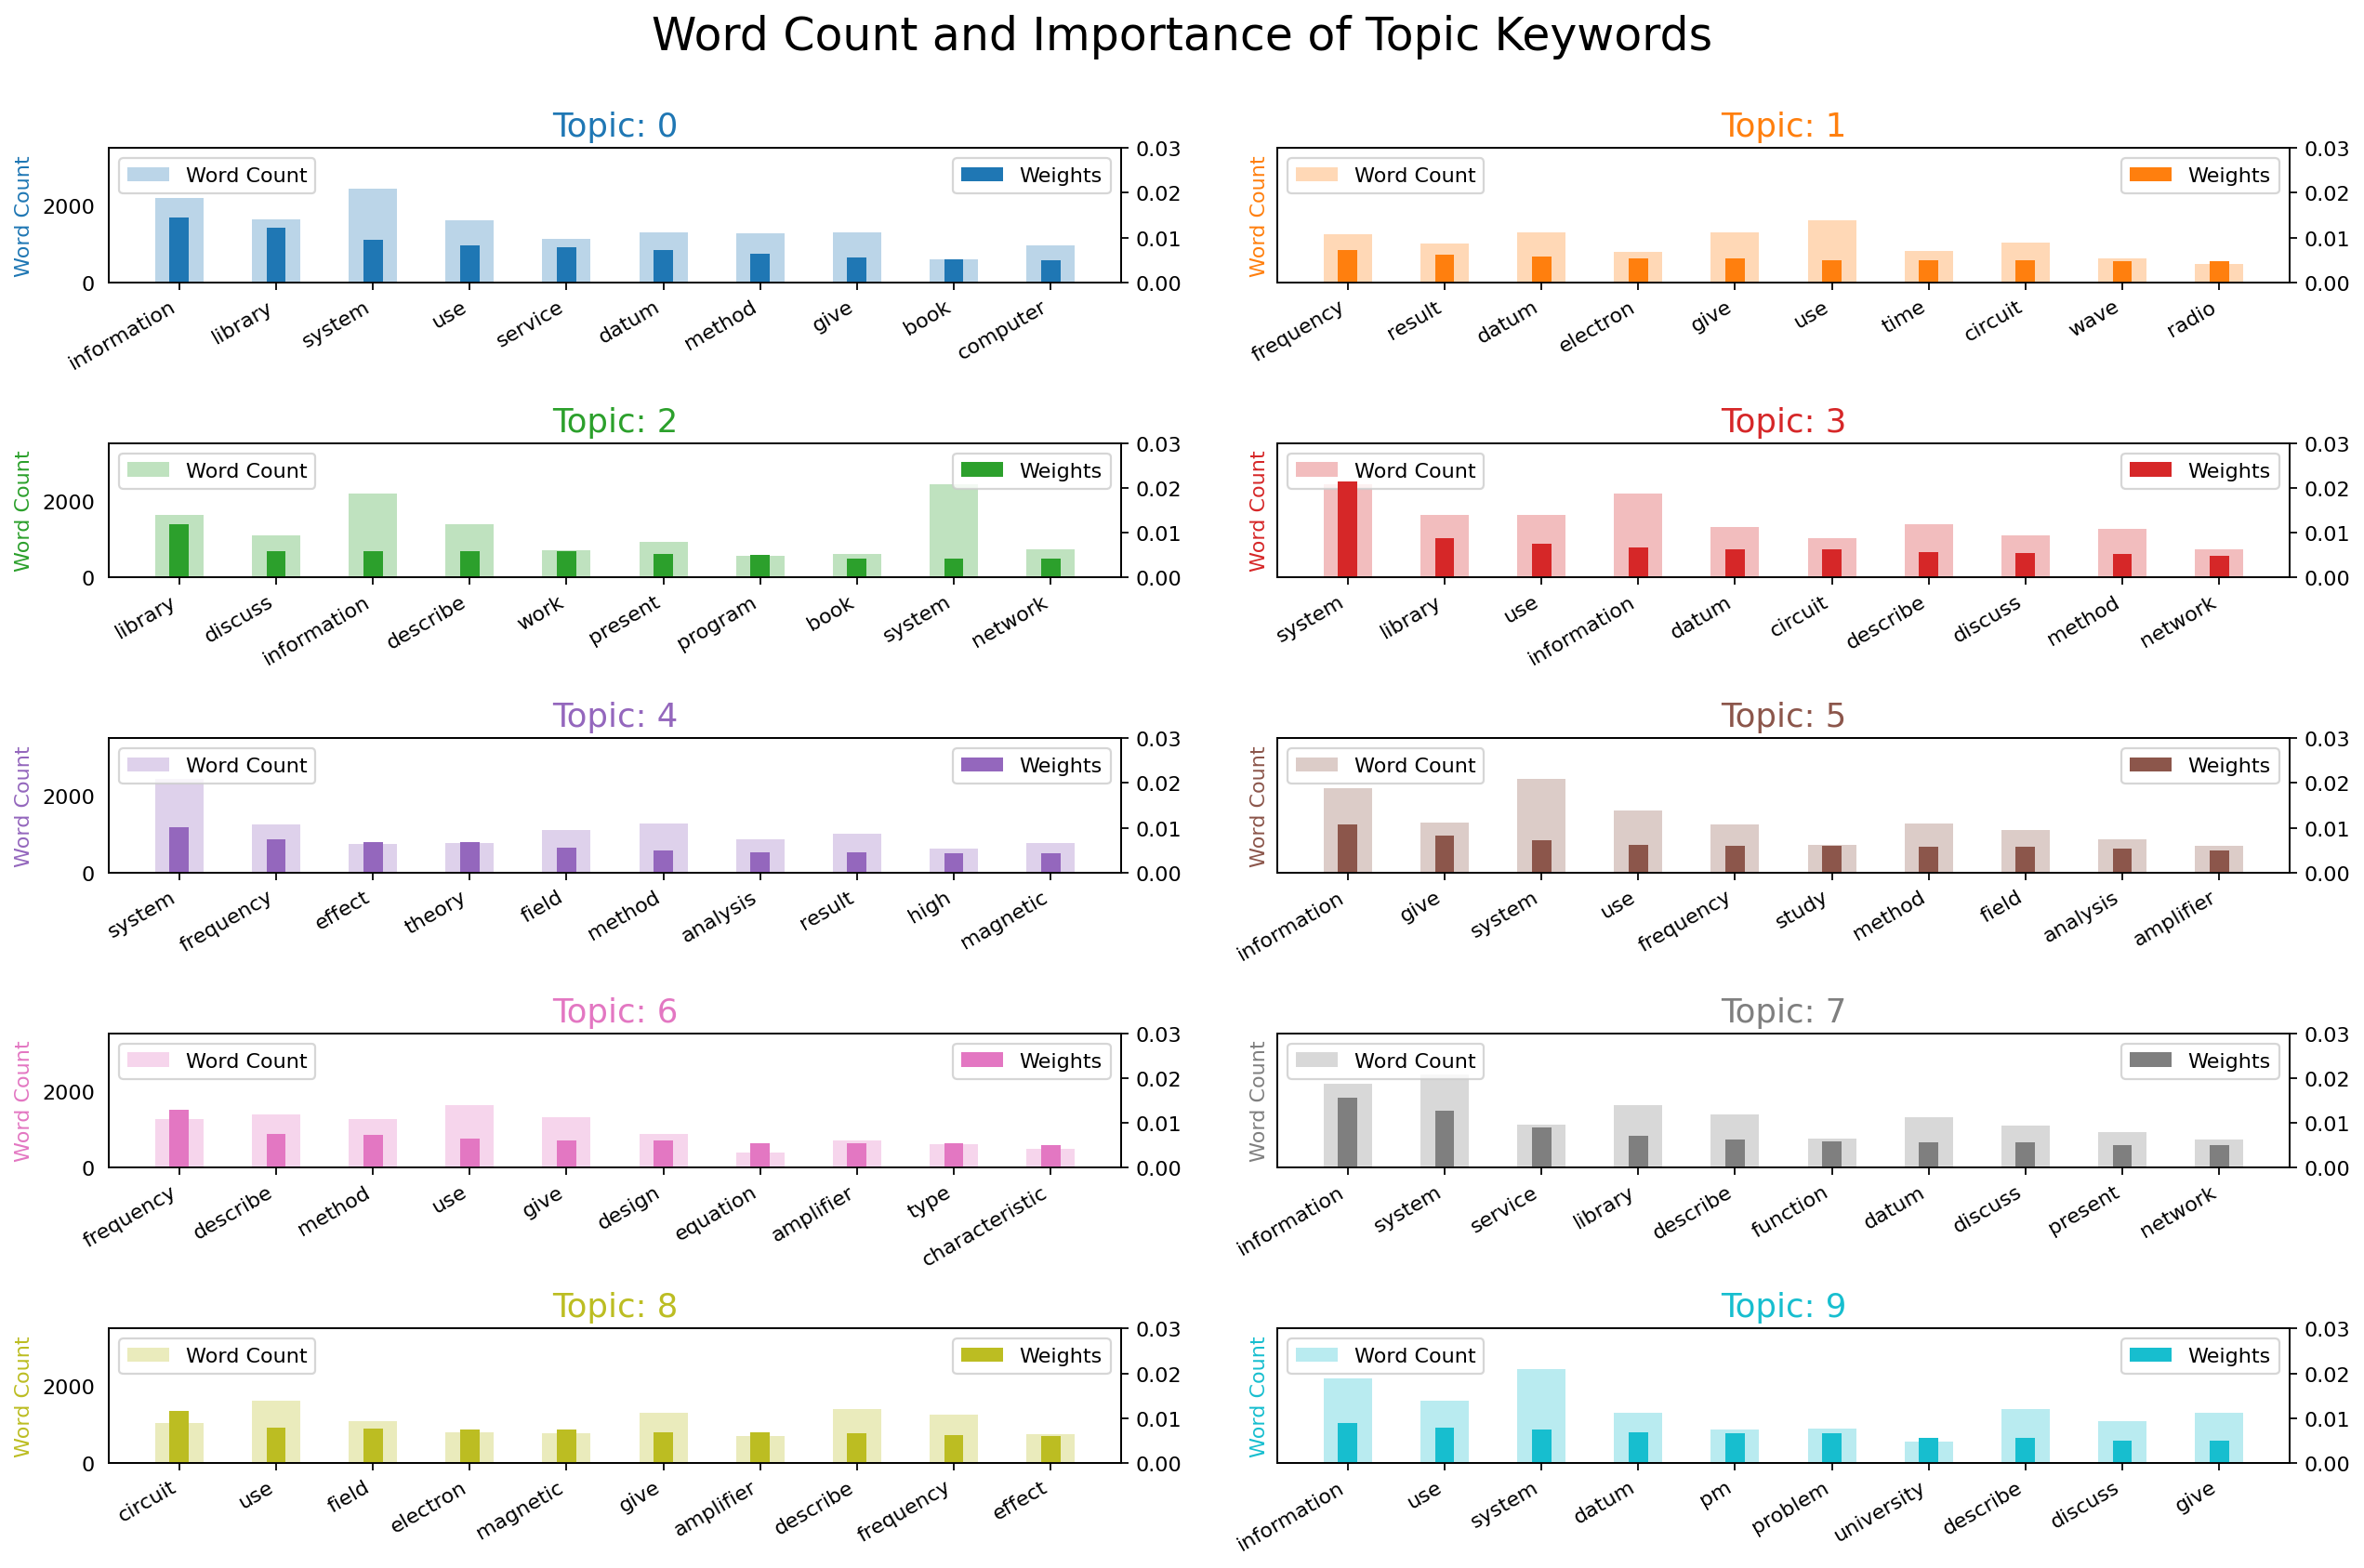

In [234]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in prep_collection for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [236]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
#print(enumerate(lda_model[corpus]))
for i, row_list in enumerate(lda_model[corpus]):
    #print(i, row_list)
    topic_weights.append([w for w in row_list[0]])
#topic_weights = np.array(topic_weights)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
print(arr)
# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
#tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[[0.         0.01429865]
 [0.         0.65965784]
 [2.         0.42135203]
 ...
 [1.         0.82513356]
 [1.         0.9590714 ]
 [5.         0.96894109]]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7849 samples in 0.004s...
[t-SNE] Computed neighbors for 7849 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7849


C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 2000 / 7849
[t-SNE] Computed conditional probabilities for sample 3000 / 7849
[t-SNE] Computed conditional probabilities for sample 4000 / 7849
[t-SNE] Computed conditional probabilities for sample 5000 / 7849
[t-SNE] Computed conditional probabilities for sample 6000 / 7849
[t-SNE] Computed conditional probabilities for sample 7000 / 7849
[t-SNE] Computed conditional probabilities for sample 7849 / 7849
[t-SNE] Mean sigma: 0.000003


C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.482334
[t-SNE] KL divergence after 1000 iterations: 0.365617


Loading BokehJS ...

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

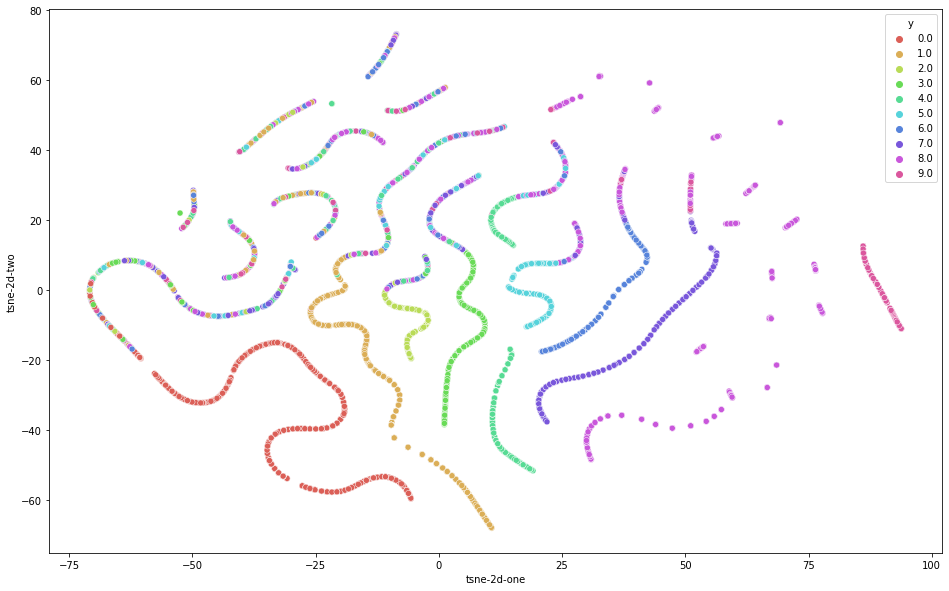

In [240]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_lda[:,0]
df_subset['tsne-2d-two'] = tsne_lda[:,1]
df_subset['y'] = df_dominant_topic['Dominant_Topic']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.99
)
